# Forecast Power Consumtion with LSTM

This notebook is based in the dataset of kaggle (https://www.kaggle.com/datasets/francoisraucent/western-europe-power-consumption) for Germany and also based on the repository of Medium.com (https://towardsdatascience.com/forecasting-the-future-power-consumption-of-germany-using-lstm-rnn-and-dnn-d8e05e7fdc0a)

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# Comprobamos la disponibilidad de GPU

physical_devices = tf.config.list_physical_devices('GPU')
print(f"Resultado physical devices: {physical_devices}")
print("Num GPUs: ", len(physical_devices))
print("GPU disponible en: ", tf.test.is_gpu_available)

Resultado physical devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs:  1
GPU disponible en:  <function is_gpu_available at 0x00000221A1AB0700>


## Data reading

In [3]:
# Read the file with the data
data = pd.read_csv(r"de.csv")
data.head(5)

,start,end,load
0,2015-01-01 00:00:00+00:00,2015-01-01 00:15:00+00:00,41917.0
1,2015-01-01 00:15:00+00:00,2015-01-01 00:30:00+00:00,41518.0
2,2015-01-01 00:30:00+00:00,2015-01-01 00:45:00+00:00,41179.0
3,2015-01-01 00:45:00+00:00,2015-01-01 01:00:00+00:00,40756.0
4,2015-01-01 01:00:00+00:00,2015-01-01 01:15:00+00:00,40618.0


In [4]:
# Drop the column 'end' - Why?? -> Because the end datetime doesn't worth for us
data_de = data.drop(['end'], axis=1)
data_de.head(5)

,start,load
0,2015-01-01 00:00:00+00:00,41917.0
1,2015-01-01 00:15:00+00:00,41518.0
2,2015-01-01 00:30:00+00:00,41179.0
3,2015-01-01 00:45:00+00:00,40756.0
4,2015-01-01 01:00:00+00:00,40618.0


In [5]:
# Creating train and test dataset
print(f"Creating train dataset")
train_set = data_de.loc[data_de['start'] <= '2019-05-31 00:00']
test_set = data_de.loc[data_de['start'] > '2019-05-31 00:00']
display(train_set.head(2))

# Change index from number to date and hour of 'start'
print("\n\n")
print(f"Change index from number to date and hour of 'start'")
train_set = train_set.set_index('start')
test_set = test_set.set_index('start')
display(train_set.head(2))

# Convert to datatime object 
print("\n\n")
print(f"Convert to datEtime object")
train_set.index = pd.to_datetime(train_set.index)
test_set.index = pd.to_datetime(test_set.index)
display(train_set.head(2))

# Se devuelve el objeto agrupado por hora?
print("\n\n")
print(f"Se devuelve el objeto agrupado por hora?")
train_set = train_set.groupby(pd.Grouper(freq='h')).sum()
test_set = test_set.groupby(pd.Grouper(freq='h')).sum()
display(train_set.head(2))

Creating train dataset


,start,load
0,2015-01-01 00:00:00+00:00,41917.0
1,2015-01-01 00:15:00+00:00,41518.0





Change index from number to date and hour of 'start'


,load
start,
2015-01-01 00:00:00+00:00,41917.0
2015-01-01 00:15:00+00:00,41518.0





Convert to datEtime object


,load
start,
2015-01-01 00:00:00+00:00,41917.0
2015-01-01 00:15:00+00:00,41518.0





Se devuelve el objeto agrupado por hora?


,load
start,
2015-01-01 00:00:00+00:00,165370.0
2015-01-01 01:00:00+00:00,160540.0


## Visualize Data

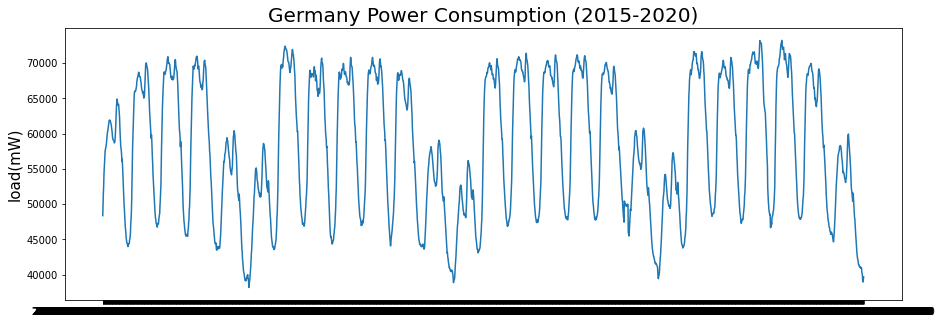

In [179]:
plt.figure(figsize=(15,5))
# Careful with the number of representatios, too much points create problems with the processing
# Is better represent a few points in the line something like 500 points or 3000 points
plt.plot(data_de['start'][500:3000], data_de['load'][500:3000])
plt.ylabel("load(mW)", fontsize = 15)
plt.yticks(fontsize=10)
plt.title("Germany Power Consumption (2015-2020)", fontsize=20)
plt.show()

In [6]:
#Boxplots

# Reset index from number to datetime format with 'start'
df = data_de.set_index('start')
df.index = pd.to_datetime(df.index)

# Subset to year and month - Didn't understand this part, create subset of year and month but how it works?
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime("%b") for d in df.index]

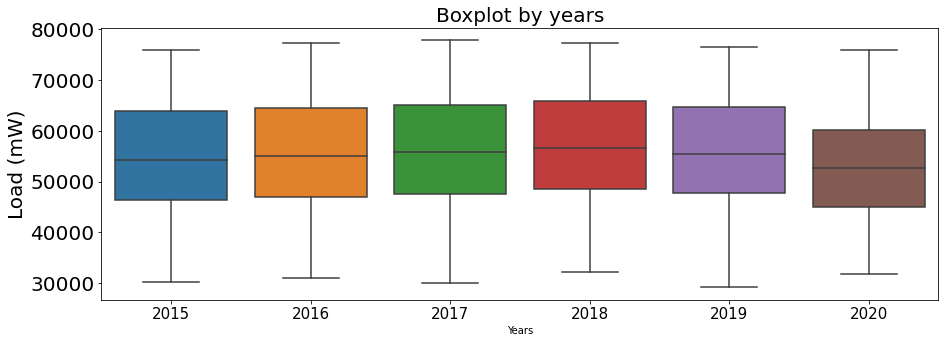

In [10]:
plt.figure(figsize=(15,5))
sns.boxplot(x = 'year', y = 'load', data = df)
plt.ylabel("Load (mW)", fontsize=20)
plt.xlabel("Years", fontsize = 10)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 15)
plt.title("Boxplot by years", fontsize = 20)
plt.show()

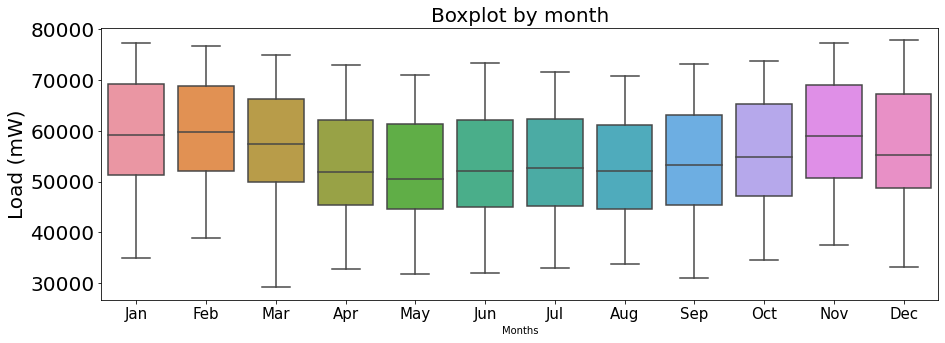

In [11]:
plt.figure(figsize=(15,5))
sns.boxplot(x = 'month', y = 'load', data = df)
plt.ylabel("Load (mW)", fontsize=20)
plt.xlabel("Months", fontsize = 10)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 15)
plt.title("Boxplot by month", fontsize = 20)
plt.show()

## Data Processing

In [14]:
# Scaling data

scaler = StandardScaler()

# Why only fit on train set???
scaler = scaler.fit(train_set[['load']])

# Scaling data for the entry of the future neural network 
train_set['load'] = scaler.transform(train_set[['load']])
test_set['load'] = scaler.transform(test_set[['load']])

# What is that??
last_n = 24

# Why this step? Is necessary do always the same? not sure of all the process
def to_sequence(x, y, seq_size=1):
    x_values = []
    y_values = []
    for i in range(len(x) - last_n):
        x_values.append(x.iloc[i:(i+last_n)].values)
        y_values.append(y.iloc[i+last_n])
    return np.array(x_values), np.array(y_values)

# Apply function
x_train, y_train = to_sequence(train_set['load'], train_set['load'], last_n)
x_test, y_test = to_sequence(test_set['load'], test_set['load'], last_n)

## Model Architecture 

In [16]:
model = Sequential()
# For deafult recurrent layers return one output, for make them return one output per timestep we must use parameters 'return_sequences'
model.add(LSTM(120, return_sequences = True, input_shape = (last_n, 1)))
model.add(LSTM(80, return_sequences = True))
model.add(LSTM(40))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 120)           58560     
                                                                 
 lstm_2 (LSTM)               (None, 24, 80)            64320     
                                                                 
 lstm_3 (LSTM)               (None, 40)                19360     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 142,281
Trainable params: 142,281
Non-trainable params: 0
_________________________________________________________________


## Training Process

In [17]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = model.fit(x_train, y_train, epochs = 25, batch_size = 32, validation_split = 0.1)

Epoch 1/25
1087/1087 [==============================] - 37s 22ms/step - loss: 0.0611 - val_loss: 0.0105
Epoch 2/25
1087/1087 [==============================] - 22s 20ms/step - loss: 0.0094 - val_loss: 0.0080
Epoch 3/25
1087/1087 [==============================] - 19s 17ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 4/25
1087/1087 [==============================] - 22s 20ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 5/25
1087/1087 [==============================] - 22s 21ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 6/25
1087/1087 [==============================] - 22s 21ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 7/25
1087/1087 [==============================] - 20s 19ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 8/25
1087/1087 [==============================] - 22s 20ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 9/25
1087/1087 [==============================] - 21s 20ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 10/25
1087/1087 [==============================] - 20s 19m

In [49]:
def ResultsViz(history_model):
    x_range = len(history_model.history['loss'])

    plt.figure(figsize=(15, 5))
    epoch_list = list(range(1,x_range+1))

    plt.plot(epoch_list, history_model.history['loss'], label='Train Loss')
    plt.plot(epoch_list, history_model.history['val_loss'], label='Validation Loss')
    plt.yticks(fontsize=15)
    plt.xticks(np.arange(0, x_range+1, 2), fontsize=15)
    plt.ylabel('Loss Value')
    plt.xlabel('Epoch')
    plt.title('Training and Validation Results', fontsize=25)
    plt.legend(loc="best", fontsize=12)
    plt.show()

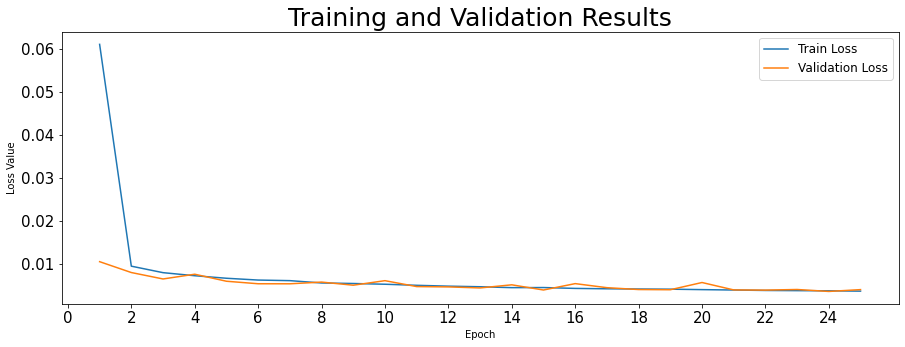

In [50]:
ResultsViz(history)

## Evaluation - Visualization of the predicction

In [133]:
# We do the predicction for the diferents datasets 

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

344/344 [==============================] - 1s 4ms/step


In [134]:
# Looking the results 
test_predict[2:10]

array([[-1.7327733 ],
       [-1.6340141 ],
       [-1.5743551 ],
       [-1.0623913 ],
       [-0.7152234 ],
       [-0.3724999 ],
       [-0.26841623],
       [-0.1292952 ]], dtype=float32)

We change the code in this point because there was a easy way to do the forecast, we found the method here: https://github.com/PacktPublishing/Practical-Time-Series-Analysis/blob/master/Chapter05/Chapter_5_Air%20Pressure_Time_Series_Forecasting_by_LSTM.ipynb

In [159]:
# We should do the inverse os the scalar because x_train and x_test are scaled

predict_train = scaler.inverse_transform(train_predict)
predict_test = scaler.inverse_transform(test_predict)
# ------------------
predict_test = np.squeeze(predict_test)
# ------------------
predict_test[2:10]

array([154534.39, 158496.55, 160890.05, 181429.72, 195357.89, 209107.75,
       213283.53, 218864.98], dtype=float32)

In [171]:
# For represent test_set, we must inverse the scaler transform
test_set[0:2]

,load
start,
2019-05-31 00:00:00+00:00,-1.690285
2019-05-31 01:00:00+00:00,-1.710948


In [172]:
val_data = scaler.inverse_transform(test_set)
# ------------------
val_data = np.squeeze(val_data)

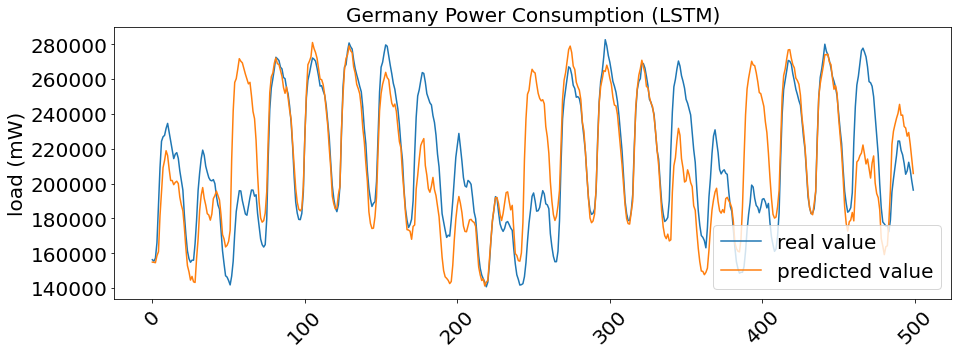

In [173]:
# test_set['load']

plt.figure(figsize=(15,5))
# Plot dataframe test/validation
plt.plot(test_val[0:500],label='real value')
plt.xticks(rotation=45)
plt.ylabel("load (mW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Germany Power Consumption (LSTM)',fontsize=20)
# Plot prediction
plt.plot(predict_test[0:500],label='predicted value')
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.show()